<!-- ![movie_recommendation_v2.gif](attachment:24c1daa1-1184-48c4-954f-6fc9d95b09d6.gif) -->

![Recommendation System](https://pbs.twimg.com/media/FmbY1N7X0AAW9mb?format=jpg&name=medium)

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Part 1: Data Preprocessing

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### 1.1 Import Libraries

In [53]:
import json
import scipy
import pickle
import warnings
import squarify
import matplotlib
import numpy as np
import pandas as pd
from pywaffle import Waffle
from functools import partial
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


%matplotlib inline
plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

### 1.2 Import the Dataset

In [54]:
credit = pd.read_csv('tmdb_5000_credits.csv')
movie = pd.read_csv('tmdb_5000_movies.csv')

In [55]:
# merge this two dataset
credit.columns = ['id','tittle','cast','crew']
movie_df = movie.merge(credit, on='id')
movie_df.head(3)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                      title  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   
2                                   Spectre           6.3        4466   

                                     tittle  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...

### 1.3 Convert date appropriate format

In [57]:
movie_df["release_date"] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
del movie_df["release_date"]

### 1.4 Transform all columns which had json string into json format
several columns has id and name leave only name for them beacause id is not so important in this case

In [58]:
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": # We need other information besides the name
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

### 1.5 Create director writer and producer columns

In [59]:
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
del movie_df["crew"]

### 1.6 Create profit column

In [60]:
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

### 1.7 Fill some missing values by most frequent one

In [61]:
for col in ["runtime", "release_year", "release_month"]:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [62]:
movie_df.head(2)

budget                                         genres  \
0  237000000  [Action, Adventure, Fantasy, Science Fiction]   
1  300000000                   [Adventure, Fantasy, Action]   

                                       homepage     id  \
0                   http://www.avatarmovie.com/  19995   
1  http://disney.go.com/disneypictures/pirates/    285   

                                            keywords original_language  \
0  [culture clash, future, space war, space colon...                en   
1  [ocean, drug abuse, exotic island, east india ...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   

                                production_companies  \
0  [Ingenious Film Partners, Twentieth Century Fo...   
1  [Walt Disney Pictures, Jerry Bruckheimer Films...   

                         production_countries     revenue  runtime  \
0  [United States of America, United Kingdom]  2787965087    162.0   
1                  [United States of America]   961000000    169.0   

     spoken_languages    status  \
0  [English, Español]  Released   
1           [English]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   

                                      title  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   

                                     tittle  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                                cast  release_year  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weave...        2009.0   
1  [Johnny Depp, Orlando Bloom, Keira Knightley, ...        2007.0   

  release_month        director         writer           producer      profit  
0      December   James Cameron  James Cameron      James Cameron  2550965087  
1           May  Gore Verbinski            NaN  Jerry Bruckheimer   661000000

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Part 2: Exploratory Data Analysis

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### 2.1 Anayze the data briefly
fastest way to get familiarize dataset and see much information

In [69]:
report = ProfileReport(movie_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 2.2 Top movies based on budget, revenue and profit 

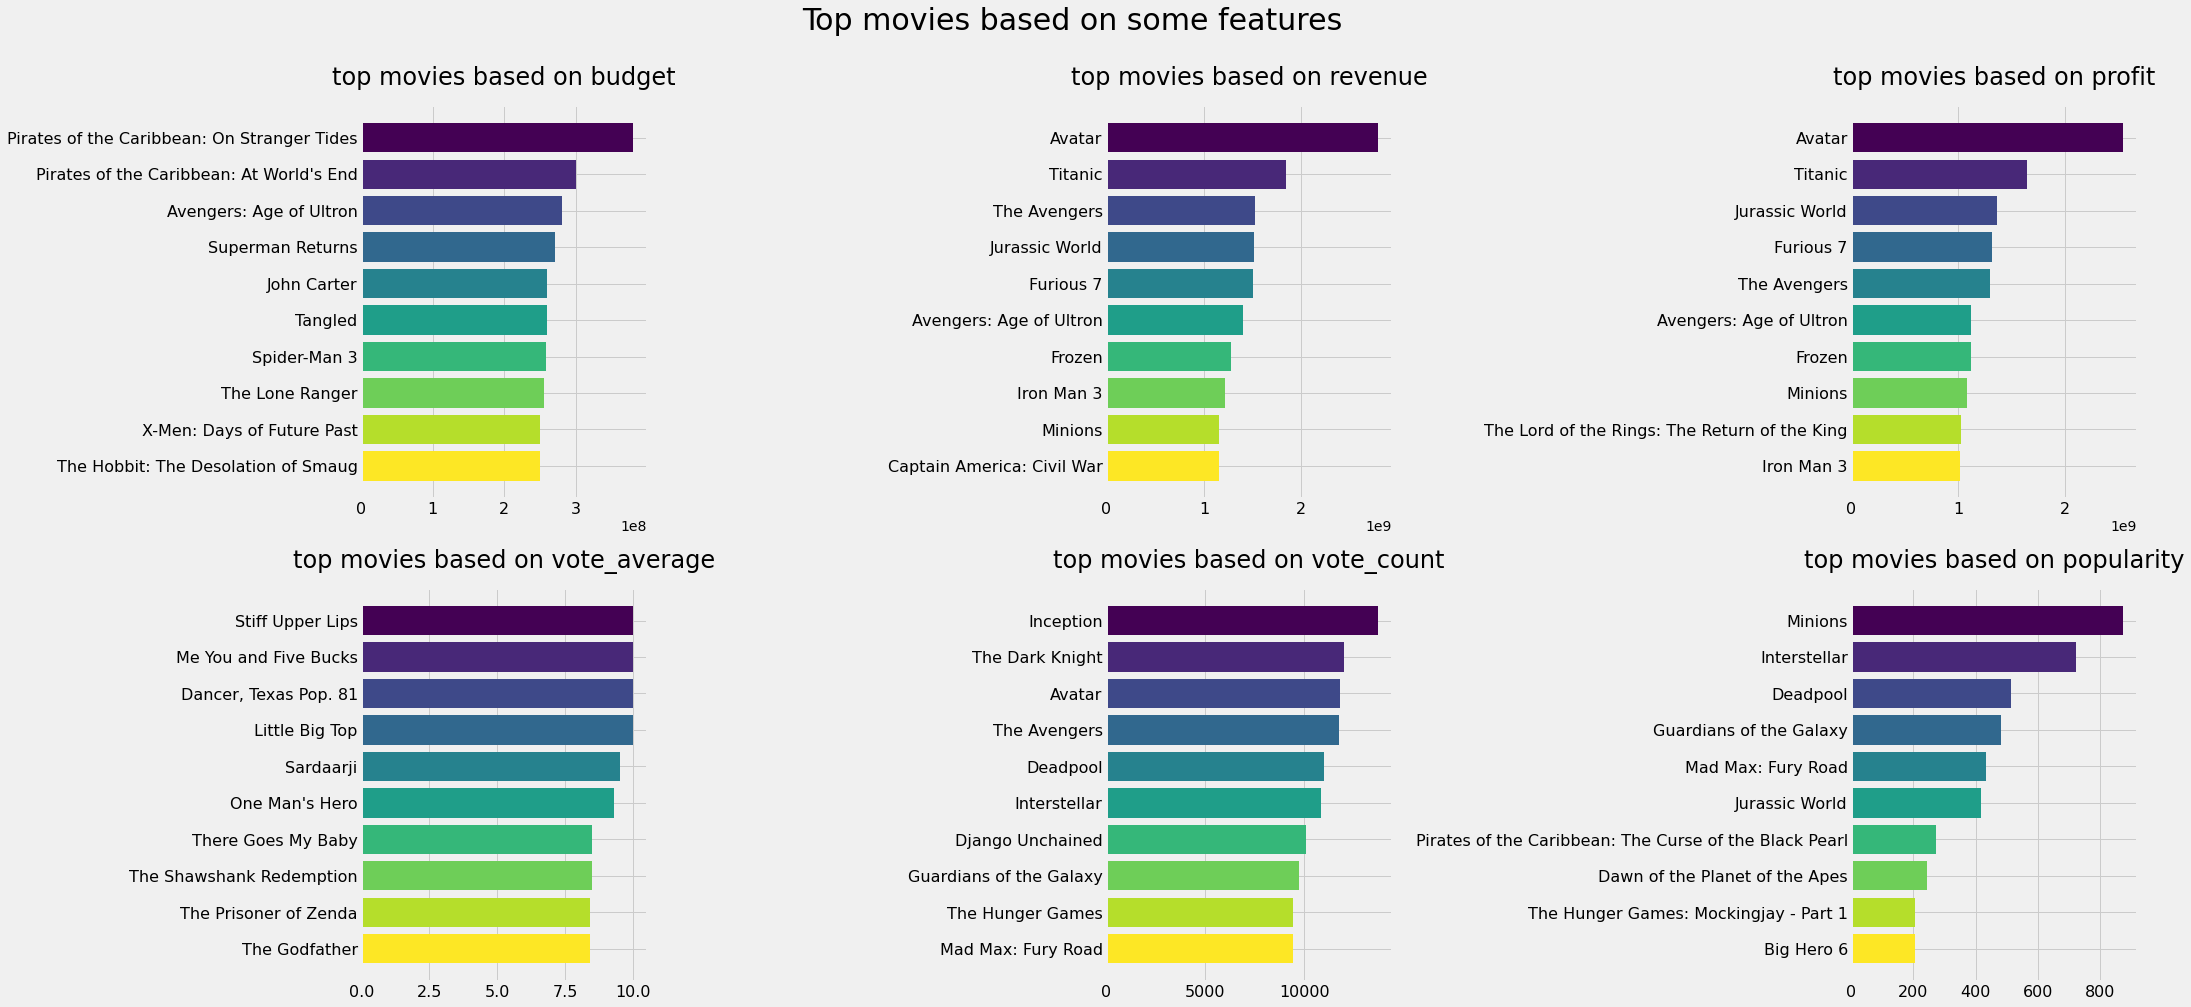

In [63]:
top_movie_num = 10
top_movies_based_on = ["budget", "revenue", "profit", "vote_average", "vote_count", "popularity"]

fig, ax = plt.subplots(len(top_movies_based_on)//3, 3, figsize=(30,14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movies_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by["title"], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f"top movies based on {col}", fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()    
    
plt.suptitle('Top movies based on some features',fontsize=30, y=1)
fig.tight_layout()

### 2.3 What types of Movies

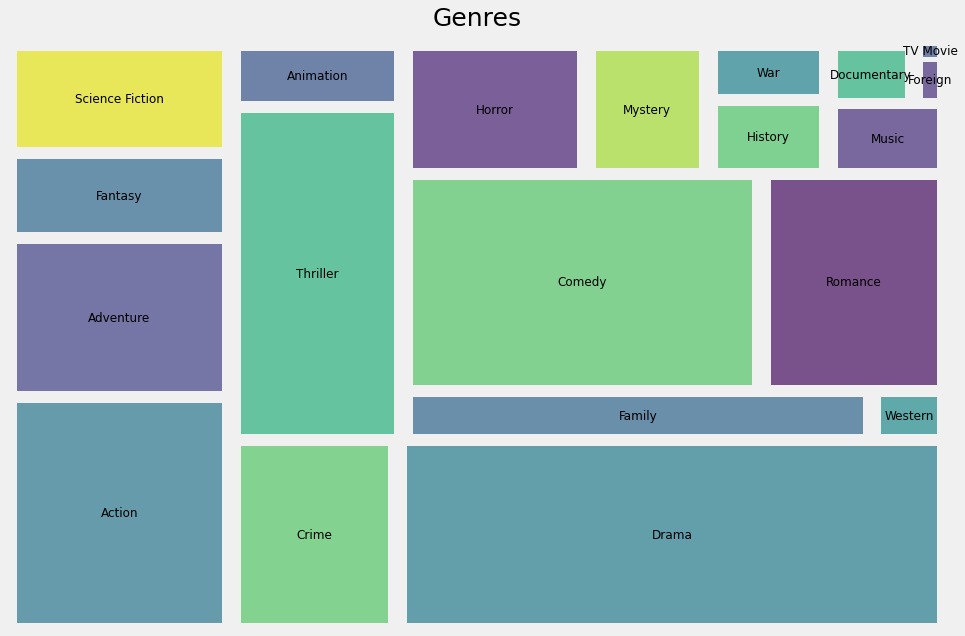

In [64]:
genres_flatten = sum(movie_df["genres"].values, []) 
genres_info = Counter(genres_flatten)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

### 2.4 What's reason of popularity

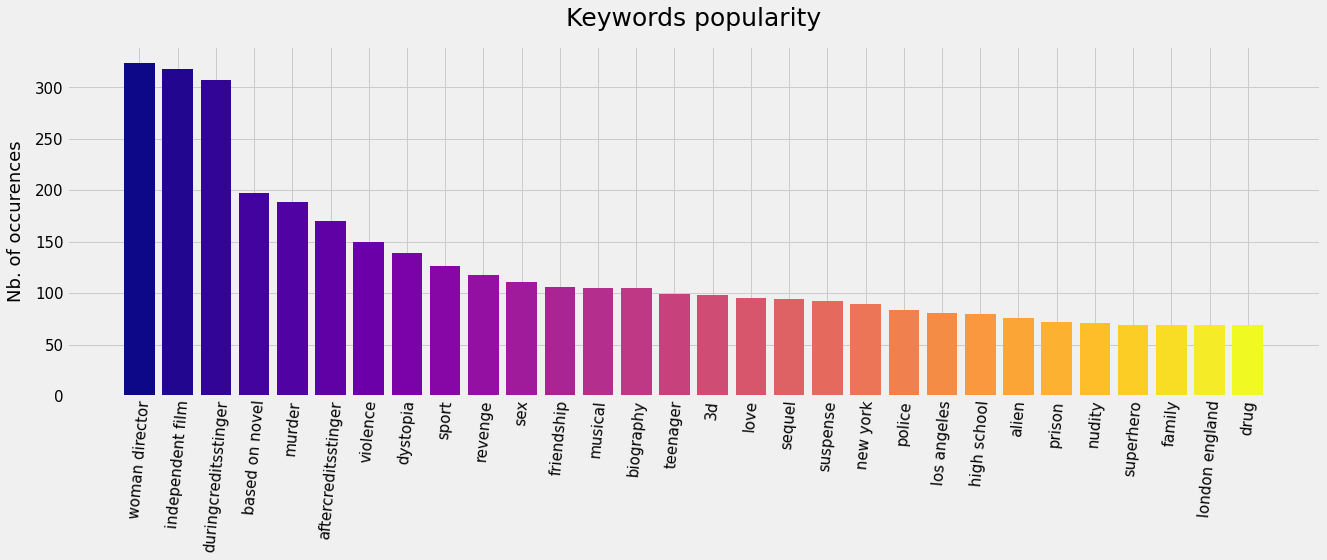

In [65]:
top_keywords_num = 30
keywords_flatten = sum(movie_df["keywords"].values, []) # keywords are list of lists
keywords_info = Counter(keywords_flatten)
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center', color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title("Keywords popularity", fontsize=25, pad=20)
plt.show()

### 2.5 Which langues most used 

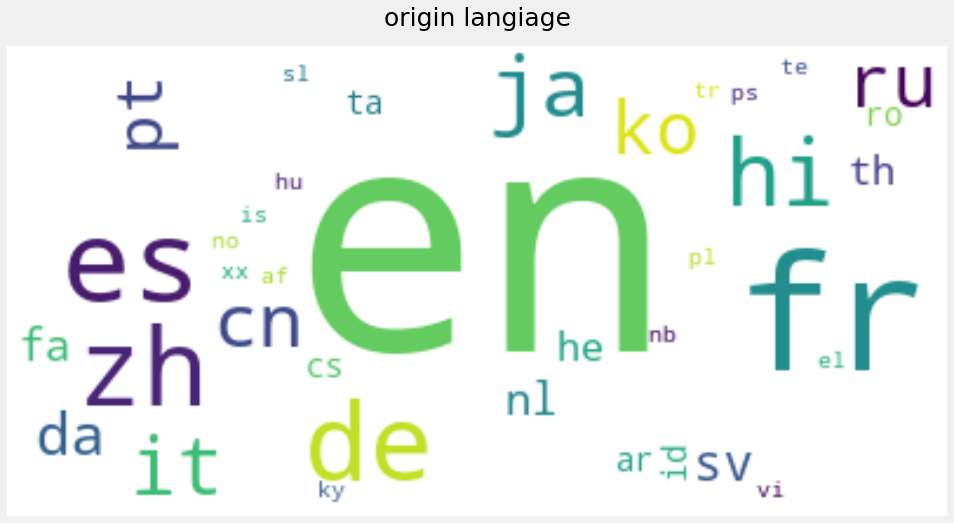

In [66]:
# plot unique cast frequency
language_info = movie_df["original_language"].value_counts()[:50]

wordcloud.generate_from_frequencies(dict(language_info))

plt.figure(figsize=(15,10))
plt.title("origin langiage", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

### 2.6 Top Countries Based on Production

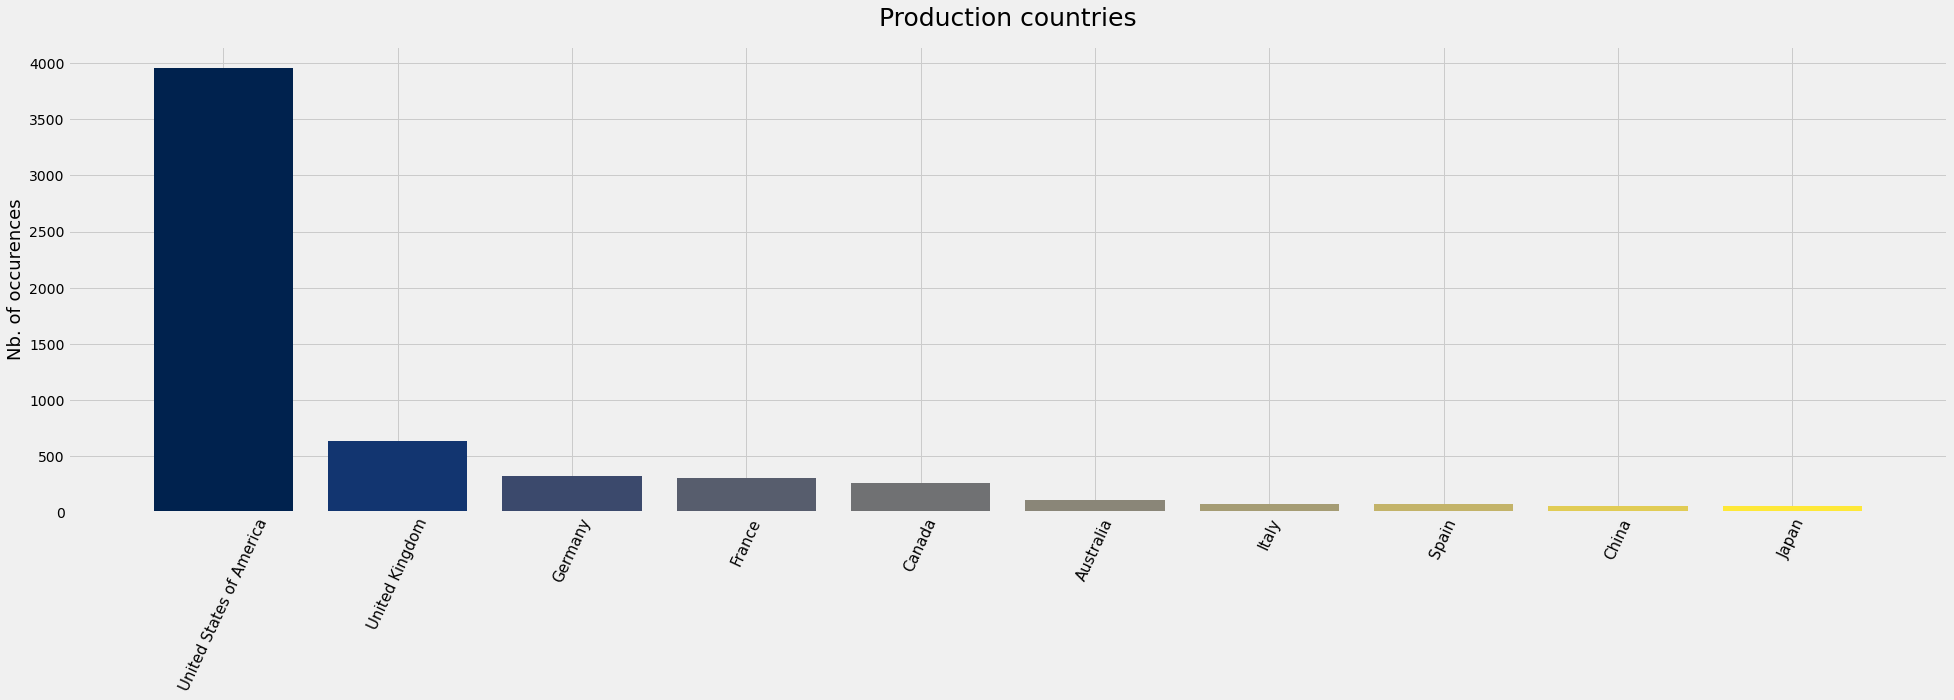

In [67]:
top_contries_num = 10
production_contries_flatten = sum(movie_df["production_countries"].values, []) # production_countries are list of lists
production_contries_info = Counter(production_contries_flatten)
top_production_contries = production_contries_info.most_common(top_contries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18)
plt.title("Production countries", fontsize=25, pad=20)
plt.bar(dict(top_production_contries).keys(), dict(top_production_contries).values(), color=plt.cm.get_cmap('cividis', top_contries_num).colors);

### 2.7 Top Production Companies

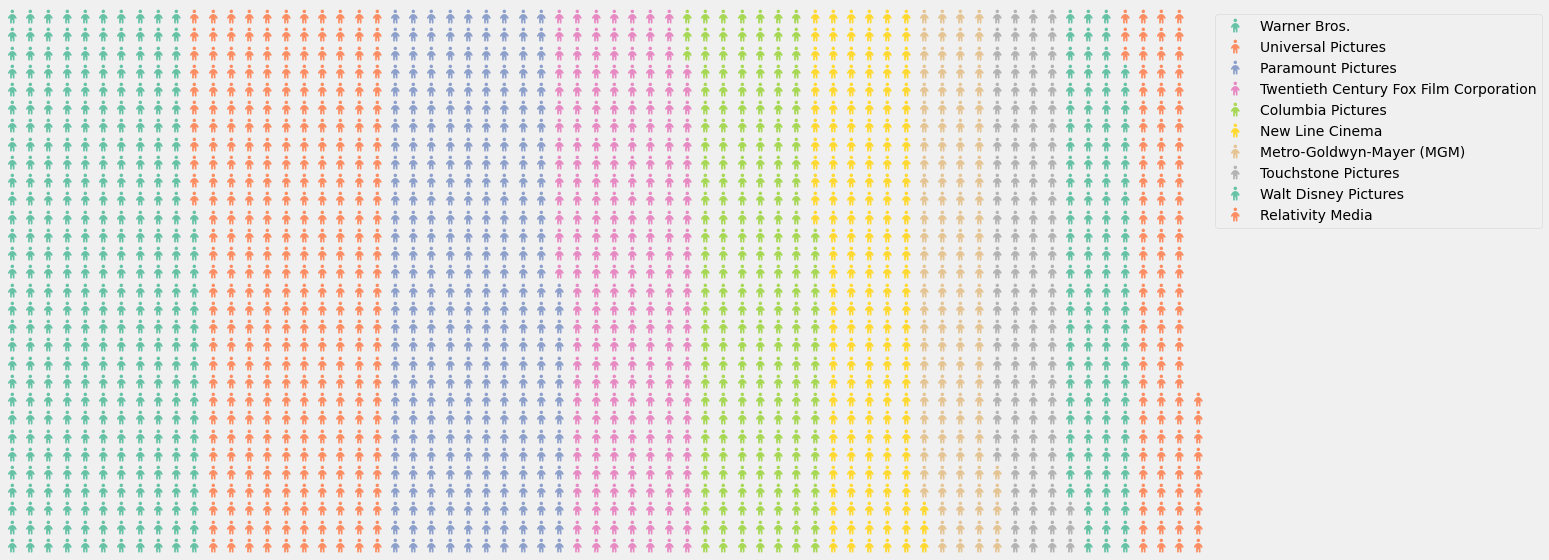

In [68]:
production_companies_flatten = sum(movie_df["production_companies"].values, []) # production_companies are list of lists
production_companies_info = Counter(production_companies_flatten)
top_production_companies = production_companies_info.most_common(10)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=dict(top_production_companies), 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', icon_size=14, 
    icon_legend=True,
    figsize=(24,8)
)

### 2.8 Unique Cast Frequency

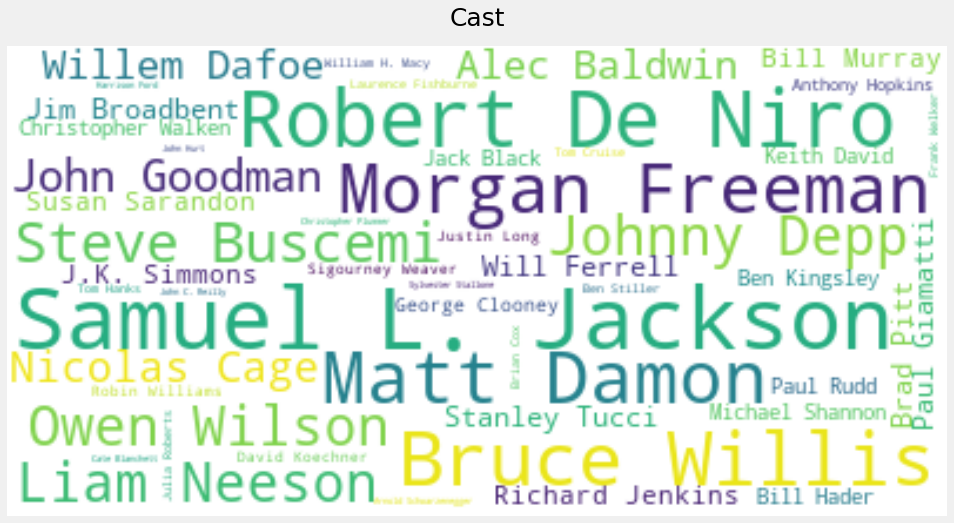

In [21]:
cast_flatten = sum(movie_df["cast"].values, []) # cast are list of lists
cast_info = Counter(cast_flatten)

wordcloud.generate_from_frequencies(dict(cast_info.most_common(50)))

plt.figure(figsize=(15,10))
plt.title("Cast", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

### 2.9 Which Year movies release most

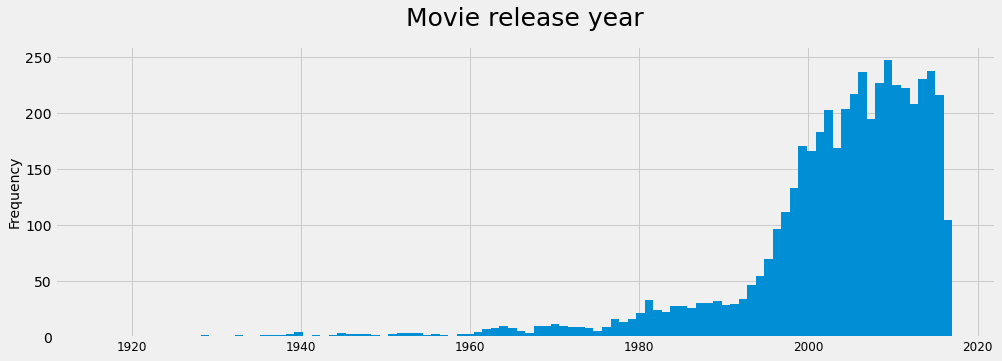

In [22]:
plt.xticks(fontsize=12)
plt.ylabel("Nb. of occurences", fontsize=14)
plt.title("Movie release year", fontsize=25, pad=20)
movie_df["release_year"].plot.hist(figsize=(15,5), bins=100);

### 2.10 Which Feature is most Correlated

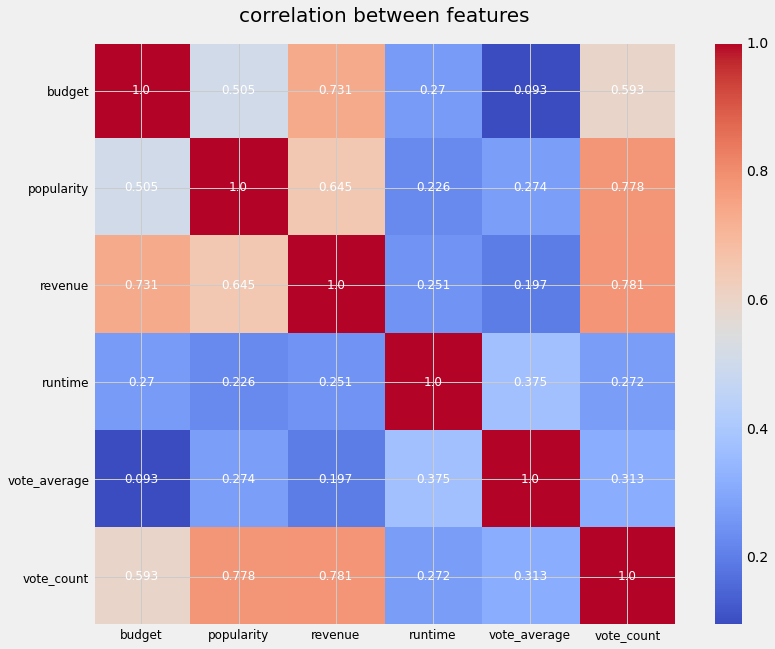

In [24]:
matrix = movie_df[["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]].corr()

f, ax = plt.subplots(figsize=(12, 10))
plt.title("correlation between features", fontsize=20, pad=20)
plt.xticks(range(len(matrix.index)), matrix.index, fontsize=12)
plt.yticks(range(len(matrix.index)), matrix.index, fontsize=12)

# adding values
for i in range(len(matrix.index)):
    for j in range(len(matrix.index)):
        text = ax.text(j, i, round(matrix.iloc[i, j],3), ha="center", va="center", color="w", fontsize=12)
        
plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar();

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Part 3: Build a Recommmendation System
There are lots of methods that use to build recommender system. In this project we build content based approach to recommend movies based on similarties. 
The system first analyses the properties of the movies that the user has previously watched and liked, such as genre, director, actors, and keywords.
Based on these characteristics, the system suggests other movies that share similar properties.
For example, if a user has previously watched and liked several action movies starring Bruce Willis, a content-based recommendation system might suggest other action movies starring Bruce Willis or similar actors.

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Weighted Average <a class="anchor" id="Weighted_average"></a>
Weighted average is a method used to calculate an overall average by assigning different weights to different values. It is often used in recommendation systems to calculate a user's overall preference for a particular item or group of items.

In a content-based recommendation system, for example, the system might assign a weight to each characteristic of an item (e.g. genre, director, actors) based on how strongly that characteristic correlates with the user's preferences. The system would then use these weights to calculate a weighted average for each item, and the items with the highest weighted averages would be recommended to the user.

Weighted average method can also be used to calculate the similarity between the items. In this case, the system assigns a weight to each characteristic of an item and calculate the weighted average of these characteristics between two items and the items with the highest weighted averages will be considered as the most similar items.

It's important to note that the weights used in the weighted average calculation are usually determined by the system's algorithm, based on the data and information available.

![](https://image.ibb.co/jYWZp9/wr.png)

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

- We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [25]:
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.9)
C, m

(6.092171559442011, 1838.4000000000015)

In [26]:
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]
q_movies.shape

(481, 27)

In [27]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [28]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

title  vote_count  vote_average     score
1881  The Shawshank Redemption        8205           8.5  8.059258
662                 Fight Club        9413           8.3  7.939256
65             The Dark Knight       12002           8.2  7.920020
3232              Pulp Fiction        8428           8.3  7.904645
96                   Inception       13752           8.1  7.863239

In [30]:
with open('movie_scores.pickle', 'wb') as handle:
    pickle.dump(q_movies[['id', 'title','score']], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Content based <a class="anchor" id="Content_based"></a>

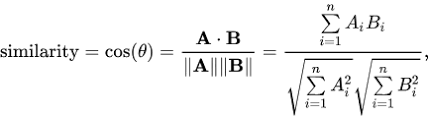

In [31]:
movie_df['overview'].head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
Name: overview, dtype: object

In [32]:
tfidf = TfidfVectorizer(stop_words='english')

movie_df['overview'] = movie_df['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(movie_df['overview'])
tfidf_matrix.shape

(4803, 20978)

In [33]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

In [34]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

In [35]:
get_recommendations('The Godfather: Part II')

title  similarity
0             The Godfather    0.412329
1   The Godfather: Part III    0.259649
2  An American in Hollywood    0.121267
3       A Most Violent Year    0.111731
4                    Casino    0.110821

In [36]:
get_recommendations('The Avengers')

title  similarity
0  Avengers: Age of Ultron    0.146374
1                  Plastic    0.122791
2                  Timecop    0.110385
3       This Thing of Ours    0.107529
4    Thank You for Smoking    0.106203

In [37]:
get_recommendations('Pulp Fiction')

title  similarity
0       The Sting    0.132020
1  All or Nothing    0.114761
2   Sliding Doors    0.111997
3       Locker 13    0.111056
4     The Fighter    0.101718

In [39]:
# save data for future use
scipy.sparse.save_npz('tfidf_matrix.npz', tfidf_matrix)

with open('movie_df.pickle', 'wb') as handle:
    pickle.dump(movie_df[["id","title"]], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Content based with more features <a class="anchor" id="Content_based_with_more_features"></a>

In [40]:
# leave only top values for some features
# for example we dont need to take all casts
features = ['cast', 'keywords', 'genres']
top_num = 5
for feature in features:
    movie_df[feature] = movie_df[feature].apply(lambda x: x[:top_num] if isinstance(x, list) else [])

In [41]:
# remove spaces for some features
# because we don't need "Johnny Depp" and "Johnny Galecki" as the same
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''
    
features = ['cast', 'keywords', 'genres', 'director', "writer", "producer", "production_companies", "production_countries"]

for feature in features:
    movie_df[feature] = movie_df[feature].apply(clean_data)

In [42]:
def create_joined_features(x):
    return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])

movie_df["join_features"] = movie_df.apply(create_joined_features, axis=1)

In [43]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_df['join_features'])
count_matrix.shape

(4803, 24176)

In [44]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

movie_df = movie_df.reset_index()
indices = pd.Series(movie_df.index, index=movie_df['title'])

In [45]:
get_recommendations('The Godfather: Part II', cosine_sim2)

title  similarity
0  The Godfather: Part III    0.559503
1         The Conversation    0.487950
2            The Godfather    0.410391
3           Apocalypse Now    0.350000
4            The Rainmaker    0.316228

In [46]:
get_recommendations('The Avengers', cosine_sim2)

title  similarity
0              Avengers: Age of Ultron    0.804030
1                           Iron Man 2    0.628828
2  Captain America: The Winter Soldier    0.611111
3           Captain America: Civil War    0.540621
4                 Thor: The Dark World    0.514496

In [47]:
get_recommendations('Pulp Fiction', cosine_sim2)

title  similarity
0  Kill Bill: Vol. 2    0.410391
1  Kill Bill: Vol. 1    0.391293
2       Jackie Brown    0.378517
3              Basic    0.300376
4     Reservoir Dogs    0.300376

![SNAR](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)